# Simulating Heisenberg spin chains in Python using QuTiP

Heisenberg spin chains are 1D spin lattices with coupling interaction, $J$. They are the simplest formulation of the quantum Heisenberg model. The quantum Heisenberg model is similar to the classical Ising model, however, the Heisenberg model exploits Pauli spin-1/2 operators acting on composite space $(\mathbb{C}^{2})^{\otimes N}$ where $N$ is the number of particles. The XXZ spin chain is defined by the following Hamiltonian:

\begin{equation*}
H = -J\sum_{j=1}^{N-1} \left( \sigma_j^x \sigma_{j+1}^x + \sigma_j^y \sigma_{j+1}^y \right) + U\sum_{j=1}^{N-1} \sigma_j^z \sigma_{j+1}^z
\end{equation*}

Where $ \sigma_{j}^{\alpha} $ are the Pauli operators acting on the jth qubit as follows:
\begin{equation*}
I^{\otimes j} \otimes \sigma^{\alpha} \otimes I^{\otimes (N-j)}
\end{equation*}

In this notebook we will be comparing two quantities: the Von Neumann entropy and Quantum Fisher Information. The Von Neumann entropy measures the bipartite entanglement of a state. The Von Neumann entropy of a subsystem, $A$ as:

\begin{equation*}
S_{A} = -tr(\rho_{A} ln(\rho_{A}))
\end{equation*}
Let $B$ represent the rest of the total system. For a pure total state, $S_{A} = S_{B}$ and $\rho_{A} = -tr_{B}(|\Psi \rangle \langle \Psi |)$

We will also calculate the Quantum Fisher information which can measure multipartite entanglement. For our system, the quantum Fisher information can be written as follows:

\begin{equation*} 
F_Q(t) = \sum_{j,k} \ s_js_k \langle \psi(t) | \sigma_j^z \sigma_{j+1}^z | \psi(t) \rangle - (\sum_{j} s_j \langle \psi(t) | \sigma_j^z  | \psi(t) \rangle)^2
\end{equation*}

where $s_j$ depends on the two subsystems being analysed. $s_j\ = +1$ for subsystem $A$ and $-1$ for subsystem $B$. The relationship between the $S_{VN}$ and $F_{Q}$ is established as [1]:
\begin{equation*} 
S_{VN}(t) \approx \frac{5}{32} F_{Q}(t)
\end{equation*}



In [1]:
import qutip as qt
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm

Initialise as a Néel state which consists of an array of alternating up and down qubits: $|\Psi_0\rangle = |↑↓↑↓ \cdots ↑↓↑ \rangle$

In [2]:
# Define basis
up, down = qt.basis(2,0), qt.basis(2,1)
N = 10 

#Our initial state
psi0 = [up if i % 2 == 0 else down for i in range(N)]

#Convert array into state vector using tensor product
psi0 = qt.tensor(psi0)

print(len(psi0.dims[0]))

10


We want to define a Hamiltonian as a function of $U$ & $J$.

\begin{equation*}
H = -J\sum_{j=1}^{N-1} \left( \sigma_j^x \sigma_{j+1}^x + \sigma_j^y \sigma_{j+1}^y \right) + U\sum_{j=1}^{N-1} \sigma_j^z \sigma_{j+1}^z
\end{equation*}

In [3]:
X, Y, Z, I = qt.sigmax(), qt.sigmay(), qt.sigmaz(), qt.qeye(2)

def Hamiltonian(J, U, N):
    """
    Gives the Hamiltonian for the XXZ spin chain
    Args:
        J (float): XX, YY coupling term
        U (float): ZZ interaction term
        N (int): Number of particles
    Returns:
        Qobj
    """    
    H = 0 * qt.tensor([I]*N)
    for i in range(N - 1):
        XX_i = qt.tensor([I] * i + [X]*2 + [I] * (N-2 - i))
        YY_i = qt.tensor([I] * i + [Y]*2 + [I] * (N-2 - i))
        ZZ_i = qt.tensor([I] * i + [Z]*2 + [I] * (N-2 - i))

        H += -J * (XX_i + YY_i) + U * ZZ_i
    
    return H

# Define Hamiltonian with J = 1, U = 0
J = 1  
U = 0
H = Hamiltonian(J, U, N)

We will define a function that takes input array containing $\psi(t)$ over time, outputs an array which contains the entropy $S_{A}$ at each time step.

Now we will define the function for $F_{Q}(t)$. For readibility we will divide the $F_{Q}(t)$ equation into two terms:

\begin{equation*}
a(t) = \sum_{j,k} s_{j} s_{k} \langle \psi(t) | \sigma_{j}^{z} \sigma_{j+1}^{z} | \psi(t) \rangle \ \ \ \ \text{and} \ \ \ \ \ b(t) = \sum_{j} s_{j} \langle \psi(t) | \sigma_{j}^{z}  | \psi(t) \rangle
\end{equation*}

where
\begin{equation*}
F_{Q}(t) = a(t) - b(t)^{2} 
\end{equation*}

Our function will take an array containing $\psi$ over time and output an array  containing $F_{Q}$ over time

In [4]:
def F_Q(state):
    """
    Returns the Quantum Fisher Information for an input state.
    Args:
        state (Qobj): state with respect to which F_Q will be calculated
    Returns:
        float
    """
    N = len(state.dims[0])

    # We will let each half of the chain be our subsystems
    s = [1 if i < N // 2 else -1 for i in range(N)]

    a = 0
    b = 0
    # Sum over j 
    for j in range(N):
        Z_j = qt.tensor([I]*j + [Z] + [I] * (N - 1 - j))

        # Sum over k
        for k in range(N):
            Z_k = qt.tensor([I]*k + [Z] + [I] * (N - 1 - k))
            a += s[j] * s[k] * qt.expect(Z_j * Z_k, state)
        
        b += s[j] * qt.expect(Z_j, state)
    
    return a - b ** 2

We will calculate the $F_{Q}(t)$ and Von Neumann entropy for values of $\ U = 0, \ 1, \ 5, \ 15$. We will evolve the  system for a total time of $T = 3$ with time spacing $dt = 0.01$. Qutip's 'sesolve' function solves the Schrodinger equation using a fourth order integration:

\begin{equation*}
\psi_{i+1} = \psi_{i} + \frac{1}{6} (k_{1} + 2k_{2} + 2k_{3} + k_{4}) \Delta t
\ \  \ \ \ \ \ \ t_{i + 1} = t_{i} + \Delta t
\end{equation*}

Where the values $k_{1}, k_{2}, k_{3}, k_{4}$ are iterated as follows:

\begin{equation*}
k_{1} = -i H \psi_{i} \ \ \ \ \ \ \ k_{2} = - i H \left( \psi_{i} + \frac{k_{1}}{2} \Delta t \right)
\end{equation*}

\begin{equation*}
k_{2} = - i H \left( \psi_{i} + \frac{k_{2}}{2} \Delta t \right) \ \ \ \ \ \ \ k_{4} = -i H (\psi_{i} + k_{3} \Delta t)
\end{equation*}

In [5]:
T = 3
dt = 0.01 
nt = int(T/dt) 
t = np.linspace(0, T, nt) #Time Array

U_list = [0, 1, 5, 15]

# Store entropy & QFI data with respect to U in lists S_u, FQ_u.
S_u = []
FQ_u = []

# Calculate Fisher information & entropy for each time step and each value of U
with tqdm(total=len(U_list) * nt, desc="Loading", unit="iteration") as pbar:
    for U in U_list:
        H = Hamiltonian(J, U, N)
        psi_t = qt.sesolve(H, psi0, t)
        
        S_list = []
        FQ_list = []
        for state in psi_t.states:
            # Calculate Fisher information
            FQ_list.append(F_Q(state))

            # Calculate partial trace & entropy
            rho_A = state.ptrace(list(range(int((N + 1) / 2))))
            S_list.append(qt.entropy_vn(rho_A))

            pbar.update(1)

        S_u.append(S_list)
        FQ_u.append(FQ_list)
            

# Store entropy array for U = 0
S_qutip = S_u[0]
%store S_qutip


Loading:   0%|          | 0/1200 [00:00<?, ?iteration/s]

Loading: 100%|██████████| 1200/1200 [00:50<00:00, 23.94iteration/s]

Stored 'S_qutip' (list)


Plot $F_{Q}(t)$ vs $S_{A}(t)$ over time for $U=0$

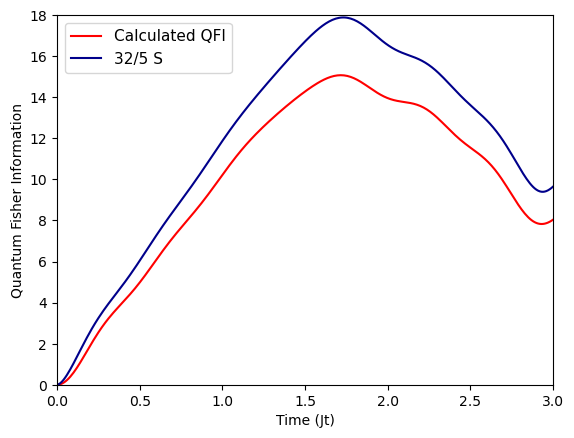

In [7]:
plt.plot(t, FQ_u[0], color='red', label='Calculated QFI')
plt.xlabel('Time (Jt)')
plt.xlim(0, 3)
plt.ylim(0, 18)
plt.ylabel('Quantum Fisher Information')
plt.plot(t, 32/5*np.array(S_u[0]), color='darkblue', label='32/5 S')
plt.legend(fontsize = 11)
plt.show()

We will calculate the ratio of the Quantum Fisher information to Von Neumann entropy for various values of $U$, to show that the linear relation between $F_{Q}$ and $S_{VN}$ does not hold for non-zero $U$. First define a function that takes the ratio between entries in two lists

In [8]:
def Ratio(list1, list2):
    
    if len(list1) != len(list2):
        print("Ratio error: Input lists aren't the same size")
        return None
    
    return [(list1[i]/list2[i]) for i in range(1, len(list1))]

When we plot the ratio of $F_{Q}(t)$ to $S_{VN}(t)$ over time, we can see that the linear relationship between $S_{VN}(t)$ and $F_{Q}(t)$ breaks down for $U \neq 0$

[]

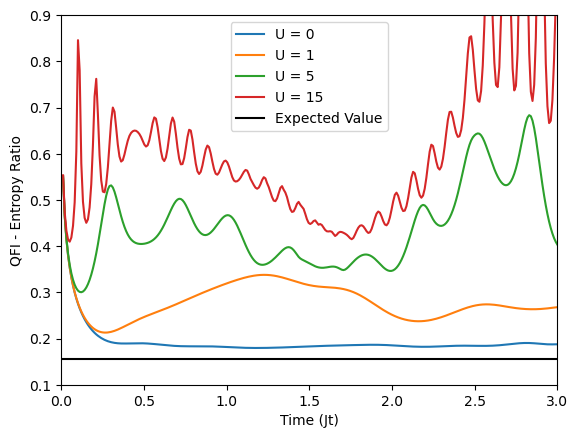

In [9]:
plt.xlim(0, 3)
plt.ylim(0.1, 0.9)
plt.xlabel('Time (Jt)')
plt.ylabel('QFI - Entropy Ratio')
for i in range(len(U_list)):
    plt.plot(t[1:], Ratio(S_u[i], FQ_u[i])[0:], label = f"U = {U_list[i]}")
plt.plot([0, T], [5/32, 5/32], label='Expected Value', color='black')
plt.legend()
plt.plot()

## References

[1] A. Smith, M. S. Kim, F. Pollmann, and J. Knolle, “Simulating quantum many-body dynamics on a current digital quantum computer,” npj Quantum Information, vol. 5, no. 1, Nov. 2019, doi: https://doi.org/10.1038/s41534-019-0217-0.